## **Práctica 1: MLLIB CON DATASET DE RETRASOS DE VUELOS**

### 1. Carga de datos

Importamos las librerías necesarias

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
import os, sys

# Ruta Andrés
os.environ['JAVA_HOME'] = 'C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot'
# Ruta Vila
# os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/jdk-17.jdk/Contents/Home'
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = SparkSession.builder.getOrCreate()

Cargamos los datos con Pyspark y mostramos las primeras 5 filas

In [4]:
# Carga de datos con Pyspark

df = spark.read.csv('full_data_flightdelay.csv', header=True, inferSchema=True)
df.show(5)

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------

Mostramos el tipo de dato de cada columna

In [5]:
# Mostramos los tipos de datos de cada columna (schema)

df.printSchema()

root
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_DEL15: integer (nullable = true)
 |-- DEP_TIME_BLK: string (nullable = true)
 |-- DISTANCE_GROUP: integer (nullable = true)
 |-- SEGMENT_NUMBER: integer (nullable = true)
 |-- CONCURRENT_FLIGHTS: integer (nullable = true)
 |-- NUMBER_OF_SEATS: integer (nullable = true)
 |-- CARRIER_NAME: string (nullable = true)
 |-- AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_FLIGHTS_MONTH: integer (nullable = true)
 |-- AIRLINE_AIRPORT_FLIGHTS_MONTH: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRPORT: integer (nullable = true)
 |-- AVG_MONTHLY_PASS_AIRLINE: integer (nullable = true)
 |-- FLT_ATTENDANTS_PER_PASS: double (nullable = true)
 |-- GROUND_SERV_PER_PASS: double (nullable = true)
 |-- PLANE_AGE: integer (nullable = true)
 |-- DEPARTING_AIRPORT: string (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: double (nullable = true)
 |-- PREVIOUS_AIRPORT: stri

Algunas características serán tratadas más adelante para transformarlas a un tipo de dato más adecuado para el entrenamiento.

In [6]:
# Mostramos número de filas y columnas

print('Número de filas:', df.count())
print('Número de columnas:', len(df.columns))

Número de filas: 6489062
Número de columnas: 26


In [7]:
# Mostramos cuantos vuelos llegaron con retraso (DEP_DEL15 = 1) y cuantos no (DEP_DEL15 = 0)

df.groupBy('DEP_DEL15').count().show()

+---------+-------+
|DEP_DEL15|  count|
+---------+-------+
|        1|1227368|
|        0|5261694|
+---------+-------+



### 2. Análisis exploratorio de datos (EDA)

In [8]:
# Miramos si existen valores nulos en cada columna, sin importar el tipo de dato

from pyspark.sql.functions import col, sum

null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+-----------------+--------+---------+----------------+----+----+----+----+----+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|
+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+------------+---------------------+---------------------+-----------------------------+------------------------+-----------------------

**NOTA**: No hay nulos en ninguna de las columnas.

In [9]:
# Hacemos un Análisis Estadístico Descriptivo

df.summary().show()

+-------+------------------+------------------+-------------------+------------+------------------+------------------+------------------+------------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+------------------+-----------------+-----------------+------------------+--------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|             MONTH|       DAY_OF_WEEK|          DEP_DEL15|DEP_TIME_BLK|    DISTANCE_GROUP|    SEGMENT_NUMBER|CONCURRENT_FLIGHTS|   NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|         PLANE_AGE|DEPARTING_AIRPORT|         LATITUDE|         LONGITUDE|    PREVIOUS_AIRPORT|               PRCP

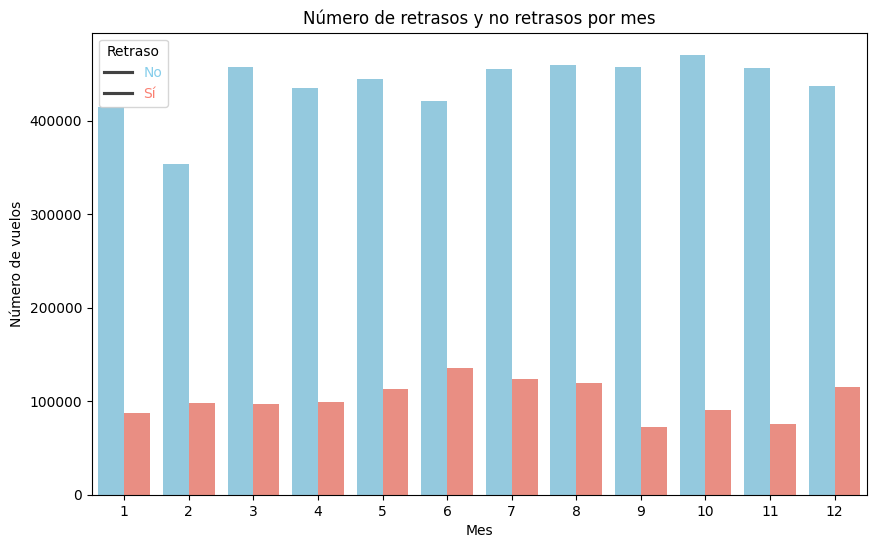

In [10]:
# Comparamos el número de retrasos y no retrasos por mes

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df_grouped = (df.groupBy("MONTH", "DEP_DEL15").count().orderBy("MONTH"))

df_pandas = df_grouped.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_pandas, x="MONTH", y="count", hue="DEP_DEL15", palette=["skyblue", "salmon"])
plt.title("Número de retrasos y no retrasos por mes")
plt.xlabel("Mes")
plt.ylabel("Número de vuelos")
plt.legend(title="Retraso", labels=["No", "Sí"], labelcolor=["skyblue", "salmon"])
plt.show()

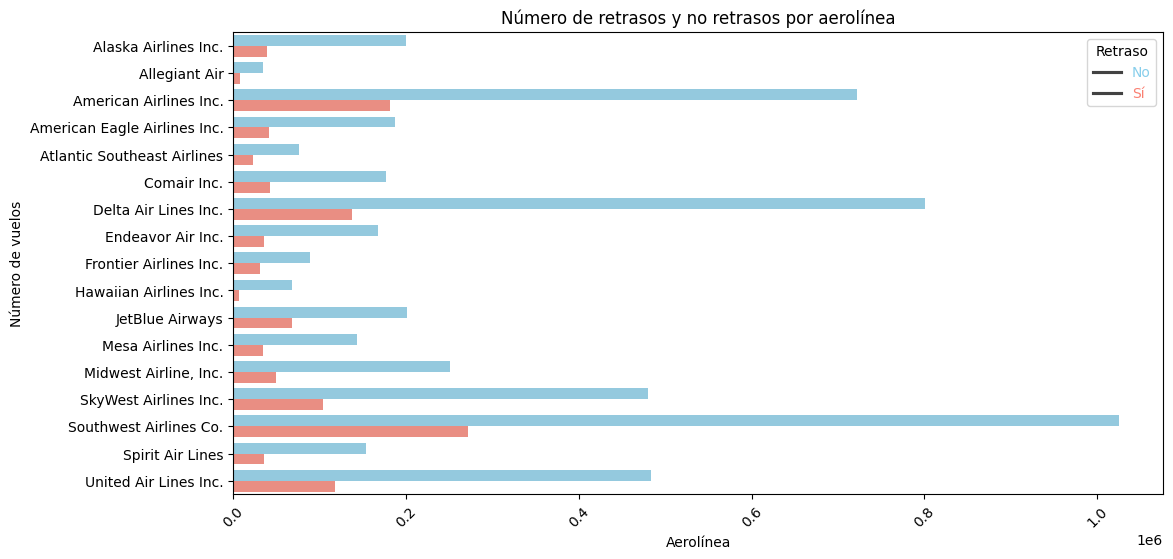

In [11]:
# Comparamos los vuelos con y sin retraso en cada aerolínea

df_grouped_airline = (df.groupBy("CARRIER_NAME", "DEP_DEL15").count().orderBy("CARRIER_NAME"))
df_pandas_airline = df_grouped_airline.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_pandas_airline, y="CARRIER_NAME", x="count", hue="DEP_DEL15", palette=["skyblue", "salmon"])
plt.title("Número de retrasos y no retrasos por aerolínea")
plt.xlabel("Aerolínea")
plt.ylabel("Número de vuelos")
plt.legend(title="Retraso", labels=["No", "Sí"], labelcolor=["skyblue", "salmon"])
plt.xticks(rotation=45)
plt.show()

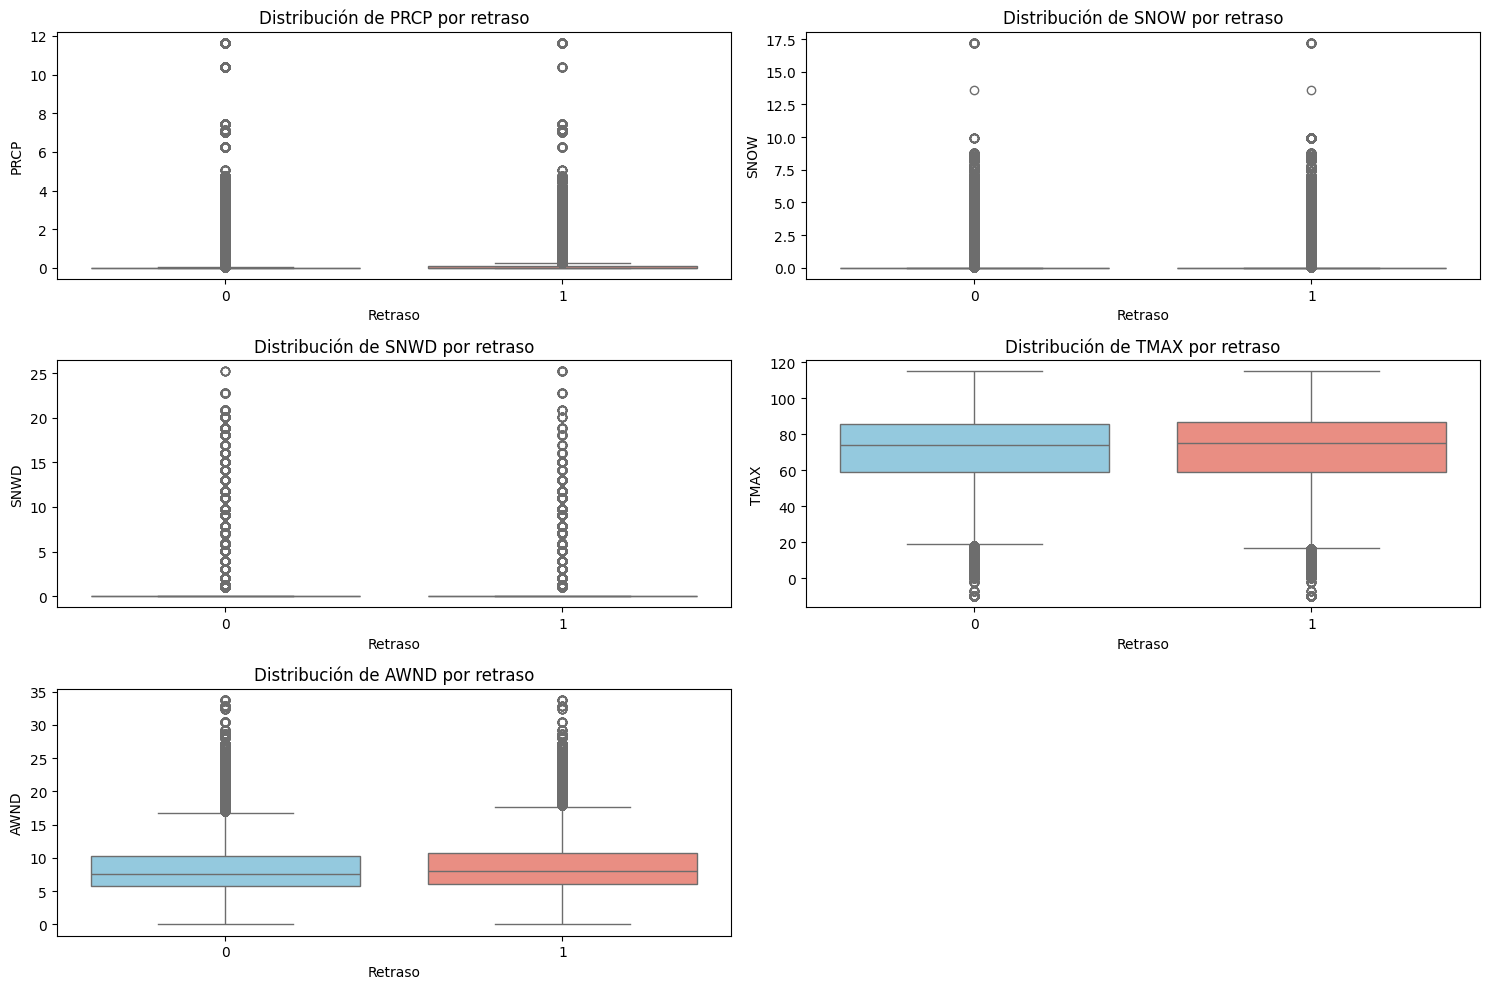

In [12]:
# Hacemos un análisis entre los retrasos y no con las variables relacionadas con la climatología (PRCP, SNOW, SNWD, TMAX, AWND)

df_weather = df.select("PRCP", "SNOW", "SNWD", "TMAX", "AWND", "DEP_DEL15")
df_weather_pandas = df_weather.toPandas()

plt.figure(figsize=(15, 10))
for i, column in enumerate(df_weather_pandas.columns[:-1], 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df_weather_pandas, x="DEP_DEL15", y=column, palette=["skyblue", "salmon"], hue="DEP_DEL15", legend=False)
    plt.title(f"Distribución de {column} por retraso")
    plt.xlabel("Retraso")
    plt.ylabel(column)
plt.tight_layout()
plt.show()

El dataset está desbalanceado, ya que la mayoría de los vuelos no tienen retraso (considerando retraso > 15 minutos).

Hacemos undersampling para balancear las clases y reducir el tamaño del dataset.

In [ ]:
# Como hay más vuelos sin retraso que con retraso, el dataset está desbalanceado
# Para balancearlo, vamos a hacer un undersampling de los vuelos sin retraso

df_delay = df.filter(df.DEP_DEL15 == 1)
df_no_delay = df.filter(df.DEP_DEL15 == 0)
df_no_delay = df.filter(df.DEP_DEL15 == 0).sample(False, df_delay.count() / df_no_delay.count(), seed=42)
df_balanced = df_delay.union(df_no_delay)

print('Número de filas después del balanceo:', df_balanced.count())
print("Número de vuelos con y sin retraso después del balanceo:")
print("Con retraso:", df_balanced.filter(df_balanced.DEP_DEL15 == 1).count())
print("Sin retraso:", df_balanced.filter(df_balanced.DEP_DEL15 == 0).count())

Número de filas después del balanceo: 2455100
Número de vuelos con y sin retraso después del balanceo:
Con retraso: 1227368
Sin retraso: 1227732


In [ ]:
# Guardamos el dataset balanceado en un nuevo archivo CSV
df_balanced.coalesce(1).write.csv('balanced_flightdelay_data.csv', header=True, mode='overwrite')

### 3. Preprocesado

In [14]:
# Cargamos el nuevo dataset balanceado
df = spark.read.csv('balanced_data_flightdelay.csv', header=True, inferSchema=True)

Mapear las variables categóricas a numéricas usando StringIndexer


In [15]:
# Mapear las variables categóricas a numéricas usando StringIndexer
from pyspark.ml.feature import StringIndexer

categorical_columns = ["DEP_TIME_BLK", "CARRIER_NAME", "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT"]

indexers = StringIndexer(inputCols=categorical_columns, outputCols=[col+"_index" for col in categorical_columns])
string_indexer_model = indexers.fit(df).transform(df)
string_indexer_model.show(5)

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+------------------+------------------+-----------------------+----------------------+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|DEP_TIME_BLK_index|CARRIER_NAME_index|DEPARTING_AIRPORT_index|PREVIOUS_AIRPORT_index|
+-----+-----------+---------+------------+--------

In [16]:
# OneHotEncoder las variables categóricas
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCols=indexers.getOutputCols(), outputCols=[x + "_ohe" for x in categorical_columns])
categoricals_encoded = encoder.fit(string_indexer_model).transform(string_indexer_model)
categoricals_encoded.show(5)

+-----+-----------+---------+------------+--------------+--------------+------------------+---------------+--------------------+---------------------+---------------------+-----------------------------+------------------------+------------------------+-----------------------+--------------------+---------+--------------------+--------+---------+----------------+----+----+----+----+----+------------------+------------------+-----------------------+----------------------+----------------+----------------+---------------------+--------------------+
|MONTH|DAY_OF_WEEK|DEP_DEL15|DEP_TIME_BLK|DISTANCE_GROUP|SEGMENT_NUMBER|CONCURRENT_FLIGHTS|NUMBER_OF_SEATS|        CARRIER_NAME|AIRPORT_FLIGHTS_MONTH|AIRLINE_FLIGHTS_MONTH|AIRLINE_AIRPORT_FLIGHTS_MONTH|AVG_MONTHLY_PASS_AIRPORT|AVG_MONTHLY_PASS_AIRLINE|FLT_ATTENDANTS_PER_PASS|GROUND_SERV_PER_PASS|PLANE_AGE|   DEPARTING_AIRPORT|LATITUDE|LONGITUDE|PREVIOUS_AIRPORT|PRCP|SNOW|SNWD|TMAX|AWND|DEP_TIME_BLK_index|CARRIER_NAME_index|DEPARTING_AIRPORT_ind

En un primer lugar vamos a seleccionar todas las características